In [1]:
import numpy as np
import pylab as plt
import scipy.ndimage
import scipy.io
import albumentations
import torch
import torchvision.transforms as transforms

TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.225])
])

AUGMENTATION = albumentations.Compose([
    albumentations.CLAHE(p=1.),
    albumentations.Resize(256, 256),
])

def img2uint8(img):
    img -= img.min()
    img /= img.max()
    img *= 255.
    return img.astype(np.uint8)


In [2]:
import sys
sys.path.append('../utils/')
from models import ENet

In [3]:
img = scipy.io.loadmat('../data/cse-york/mrimages/sol_yxzt_pat32.mat')['sol_yxzt']
mask = scipy.io.loadmat('../data/cse-york/manual_seg/manual_seg_32points_pat32.mat')['manual_seg_32points']

In [4]:
plt.imshow(img[:,:,5,1])
plt.show()

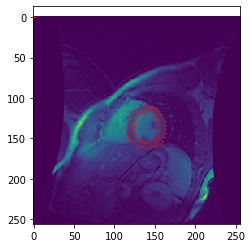

In [5]:
contour = mask[5][1]
plt.imshow(img[:,:,5,1])
plt.scatter(x=contour[:,0], y=contour[:,1], c='r', s=1)
plt.show()

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load('/Users/airplaneless/source/projects/medsegmentation/models/unet-resnet50/unet-resnet50.pth', map_location=device)

In [7]:
img = TRANSFORM(AUGMENTATION(image=img2uint8(img[:,:,5,1].astype(float)))['image'])

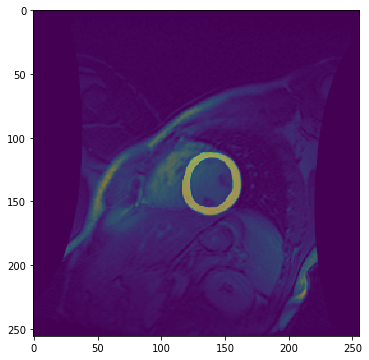

In [10]:
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[2], alpha=0.5)
plt.show()

In [9]:
img = scipy.io.loadmat('../data/cse-york/mrimages/sol_yxzt_pat1.mat')['sol_yxzt']
mask = scipy.io.loadmat('../data/cse-york/manual_seg/manual_seg_32points_pat1.mat')['manual_seg_32points']
contour = mask[10][1]
plt.imshow(img[:,:,10,1])
plt.scatter(x=contour[:,0], y=contour[:,1], c='r', s=1)
plt.show()

In [10]:
mask = np.zeros((256, 256))
mask[contour[:, 1].astype(int), contour[:, 0].astype(int)] = 1
mask = scipy.ndimage.morphology.binary_dilation(mask, iterations=5)
mask = scipy.ndimage.morphology.binary_erosion(mask, iterations=5)

In [11]:
plt.imshow(img[:,:,10,1])
plt.imshow(mask, alpha=0.5)
plt.show()